# V. Weather Predictions: 'Classic' Machine Learning Models Vs Keras

There's no shortage of online tutorials on specific data science tasks. What's harder to find are tutorials that connect the dots for newcomers, and help them explore the next phase once they've build up some level of familiarity in an area, say, machine learning basics.

After spending a good part of 2019 learning the basics of machine learning, I was keen to start experimenting with some rudimentary deep learning. But there wasn't an obvious way to start. So I decided to pull together the materials I had found on the subject, and rustled up a series of notebooks that would hopefully help others who are looking to do the same.

In these notebooks, I use a mix of machine learning and deep learning techniques to try to predict the rain pattern in Singapore in December 2019 (validation set). The models will be trained on 37 years of weather data in Singapore, from Jan 01 1983 to the end of November in 2019. 

CAVEAT: While this dataset spans 37 years, it contains just under 13,500 rows of data. It is fair to ask whether you need deep learning for a dataset like this, and whether it necessarily produces better results.

Frankly, these questions don't matter much to me as a newcomer to data science. Massive real-world datasets are hard to come by, especially in Singapore. I much prefer to continue experimenting and learning new techniques, instead of waiting for the perfect dataset to drop on my lap.

# PART 2: KERAS CLASSIFIER WITH GRID SEARCH

In notebook 5.2, I'll run the same experiment with a Keras Classifier, and use the GridSearch feature in scikit-learn to find the best hyperparameters. Optimising a deep learning model is a challenging task, as many online articles have pointed out, so it helps to start with a more familiar feature like GridSearch.

In notebook 5.3, I'll try the relatively new Keras Tuner to see if it turns in better results. 

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function, unicode_literals

In [2]:
import joblib 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras import utils

%matplotlib inline
mpl.rcParams["figure.dpi"] = 300
%config InlineBackend.figure_format ='retina'

# 1. DATA PRE-PROCESSING

## 1.1 CREATE TARGET COLUMN 

In [3]:
# loading the dataset prepared in notebook 5.0

weather = pd.read_csv('../data/weather_model.csv')

In [4]:
# Creating a new target column
# To keep the project simple, I'll focus on predicting rainfall at a binary level - rain (1), or no rain (0)

weather['Rain_Or_Not'] = np.where(weather['Daily Rainfall Total (mm)'] > 0, 1, 0)

In [5]:
# 52.2% days with no rain, 47.8 rainy days
# The target values are slightly imbalanced in distribution, but not egregiously so
# I won't take additional steps to balance out the distribution, but feel free to consider options like SMOTE

weather['Rain_Or_Not'].value_counts()

0    7036
1    6447
Name: Rain_Or_Not, dtype: int64

In [6]:
weather.head()

,Date,Year,Month,Day,Daily Rainfall Total (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),Rain_Or_Not
0,2019-11-30,2019,11,30,9.4,27.6,32.1,25.0,6.8,28.1,1
1,2019-11-29,2019,11,29,73.4,26.5,32.0,24.0,6.1,31.3,1
2,2019-11-28,2019,11,28,9.0,27.8,31.4,25.3,7.6,27.4,1
3,2019-11-27,2019,11,27,1.8,27.5,31.5,25.4,7.2,31.3,1
4,2019-11-26,2019,11,26,0.0,28.5,33.0,25.7,10.4,34.9,0


### NOTE: 
I've left the outliers *in* in this dataset, so as to give the models the maximum amount of information possible. In dealing with actual work-place projects, there should be a serious discussion about how many outliers to remove, and the trade-offs involved.

## 1.2 GETTING DATASET READY FOR COLUMN TRANSFORMER

Scikit Learn's pipeline feature is extremely handy for streamlining the pre-processing steps. In this project, we only have numeric features. But you can incorporate categorical features easily for your own project/dataset.

In [7]:
numeric_features = [
        "Mean Temperature (°C)",
        "Maximum Temperature (°C)",
        "Minimum Temperature (°C)",
        "Mean Wind Speed (km/h)",
        "Max Wind Speed (km/h)",
]

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features)]
)

In [8]:
X = weather[
    [
        "Mean Temperature (°C)",
        "Maximum Temperature (°C)",
        "Minimum Temperature (°C)",
        "Mean Wind Speed (km/h)",
        "Max Wind Speed (km/h)",
    ]
]

y = weather["Rain_Or_Not"]

## 1.3 TRAIN-TEST-SPLIT TRAINING DATA

In [9]:
# Use sklearn's train-test split, with stratify option, 
# to maintain an equitable split given the imbalanced nature of the dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [10]:
print(X_train.shape)
print(X_test.shape)

(10786, 5)
(2697, 5)


In [11]:
print(y_train.shape)
print(y_test.shape)

(10786,)
(2697,)


# 2. DUMMY BASELINE

A baseline model helps us gauge what's the minimum level of accuracy the model must achieve in order to be acceptable. In this case, it is about 0.5, which makes sense, ie, there's an equal chance a random guess would be accurate in telling us whether it would rain or not in Singapore.

In [12]:
dummy = DummyClassifier(strategy='stratified', random_state=42)

In [13]:
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, dummy_pred))

Accuracy Score: 0.5098257322951427


# 3. KERAS + GRIDSEARCH

My code below is adapted from two very useful blogs on this subject:

* ["How to Grid Search Hyperparameters for Deep Learning Models in Python With Keras"](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/) by Jason Brownlee

* ["Hacker's Guide to Hyperparameter Tuning"](https://www.curiousily.com/posts/hackers-guide-to-hyperparameter-tuning/) by Venelin Valkov

To use GridSearch with Keras, you'll have to use the KerasClassifier wrapper (or the KerasRegressor version if you are tackling a regression problem). 

The steps involved are fairly straightforward:
* Define a function that creates and returns a Keras sequential model

* Create a pipeline incorporating preprocessing and a dictionary for the hyperparameters to be tuned.

As for how many hyperparameters to tune and which ones to choose - these are questions that require trial and error, and a compromise with time and resources available to you.

I chose to tune 6 hyperparameters - the optimizer, dropout rate, epochs, batch size, the number of hidden layers and the number of neurons in it. This took about 18 hours to run on a 6-core Mac Mini (2018). 

I've not tried this on Colab or with a GPU. Presumably it would be faster with either option. Alternatively, adjust the list of parameters - and range of values - to tune accordingly if you are concerned about the time taken.

In [11]:
# Define function that creates and returns Keras sequential model

def keras_model(neurons=1, optimizer="adam", hidden_layers=1, dropout_rate=0.0):
    model = Sequential()
    
    # Add an input layer
    model.add(Dense(1024, input_dim=5, activation="relu"))
    
    for i in range(hidden_layers):
      # Add one hidden layer
      model.add(Dense(neurons, activation="relu"))
    
    model.add(Dropout(dropout_rate))
    
    # Add an output layer
    model.add(Dense(1, activation="sigmoid"))

    model.summary()

    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model


seed = 42
np.random.seed(seed)


In [12]:
optimised_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("kc", KerasClassifier(build_fn=keras_model, verbose=1)),
    ]
)

parameters = {
    "kc__neurons": [128, 256, 512],
    "kc__optimizer": ["SGD", "RMSprop", "Adam"],
    "kc__dropout_rate": [0.1, 0.15, 0.2],
    "kc__hidden_layers": [i for i in range(1,6)],
    "kc__epochs": [10, 20, 30],
    "kc__batch_size": [16, 32, 64],
}


In [13]:
grid = GridSearchCV(
    optimised_model,
    parameters,
    cv=5,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1,
)

grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 1215 candidates, totalling 6075 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.3min
/Users/chinhonchua/opt/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 81.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 199.8min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 315.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 464.0min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 616.6min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 737.1min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 885.7min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 9

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              6144      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 137,473
Trainable params: 137,473
Non-trainable params: 0
_________________________________________________________________
Train on 10786 samples
Epoch 1/10
10786/10786 [==============================] - 1s 91us/sample - loss: 0.5367 - accuracy: 0.7352
Epoch 2/10
10786/10786 [==============================] - 0s 38us/sample - loss: 0.5182 - accuracy: 0.7512
Epoch 3/10


In [14]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.756814 using {'kc__batch_size': 32, 'kc__dropout_rate': 0.2, 'kc__epochs': 10, 'kc__hidden_layers': 1, 'kc__neurons': 128, 'kc__optimizer': 'RMSprop'}


In [15]:
y_pred = grid_result.predict(X_test)

print("Precision Score :", precision_score(y_test, y_pred))
print("Recall Score:", recall_score(y_test, y_pred))
print("f1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("")

2697/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Precision Score : 0.7577197149643705
Recall Score: 0.7418604651162791
f1 Score: 0.7497062279670975
              precision    recall  f1-score   support

           0       0.77      0.78      0.78      1407
           1       0.76      0.74      0.75      1290

    accuracy                           0.76      2697
   macro avg       0.76      0.76      0.76      2697
weighted avg       0.76      0.76      0.76      2697




## NOTE:

The Keras Classifier's precision/recall/f1 scores on the test set are better than those of the LogReg model in notebook 5.1, and are very close to the XGBClassifier's results on those metrics.

Let's see how they compare against the unseen dataset for December 2019.

# 4. USING OPTIMISED KERAS CLASSIFIER TO PREDICT RAIN PATTERN IN DEC 2019

I experienced problems saving the optimised Keras Classifier via joblib, so I'm manually loading the best parameters into a new function and pipeline.

In [14]:
def tuned_model():
    model = Sequential()
    model.add(
        Dense(
            1024,
            input_dim=5,
            activation="relu",
        )
    )
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.summary()

    model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])
    return model

In [15]:
best_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("kc", KerasClassifier(build_fn=tuned_model, verbose=1, epochs=10, batch_size=32)),
    ]
)

In [16]:
# Showing the finalised model the full training data-set, ahead of testing it on unseen data

best_model.fit(X, y)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              6144      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 137,473
Trainable params: 137,473
Non-trainable params: 0
_________________________________________________________________
Train on 13483 samples
Epoch 1/10
13483/13483 [==============================] - 2s 129us/sample - loss: 0.5298 - accuracy: 0.7409
Epoch 2/10
13483/13483 [==============================] - 1s 72us/sample - loss: 0.5135 - accuracy: 0.7523
Epoch 3/10

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['Mean Temperature (°C)',
                                                   'Maximum Temperature (°C)',
                                  

## 4.1 LOAD VALIDATION DATA SET

In [17]:
validate = pd.read_csv('../data/weather_dec2019.csv')

validate['Rain_Or_Not'] = np.where(validate['Daily Rainfall Total (mm)'] > 0, 1, 0)

In [18]:
X_validate = validate[
    [
        "Mean Temperature (°C)",
        "Maximum Temperature (°C)",
        "Minimum Temperature (°C)",
        "Mean Wind Speed (km/h)",
        "Max Wind Speed (km/h)",
    ]
]

y_validate = validate["Rain_Or_Not"]

## 4.2 GENERATE AND ASSESS PREDICTIONS BY XGB MODEL 

In [21]:
pred = best_model.predict(X_validate)

31/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 1ms/sample


In [22]:
print("Accuracy Score:", accuracy_score(y_validate, pred))

Accuracy Score: 0.8387096774193549


In [23]:
print("Precision Score :", precision_score(y_validate, pred))
print("Recall Score:", recall_score(y_validate, pred))
print("f1 Score:", f1_score(y_validate, pred))

Precision Score : 0.8461538461538461
Recall Score: 0.7857142857142857
f1 Score: 0.8148148148148148


In [24]:
cm = confusion_matrix(y_validate, pred)
cm

array([[15,  2],
       [ 3, 11]])

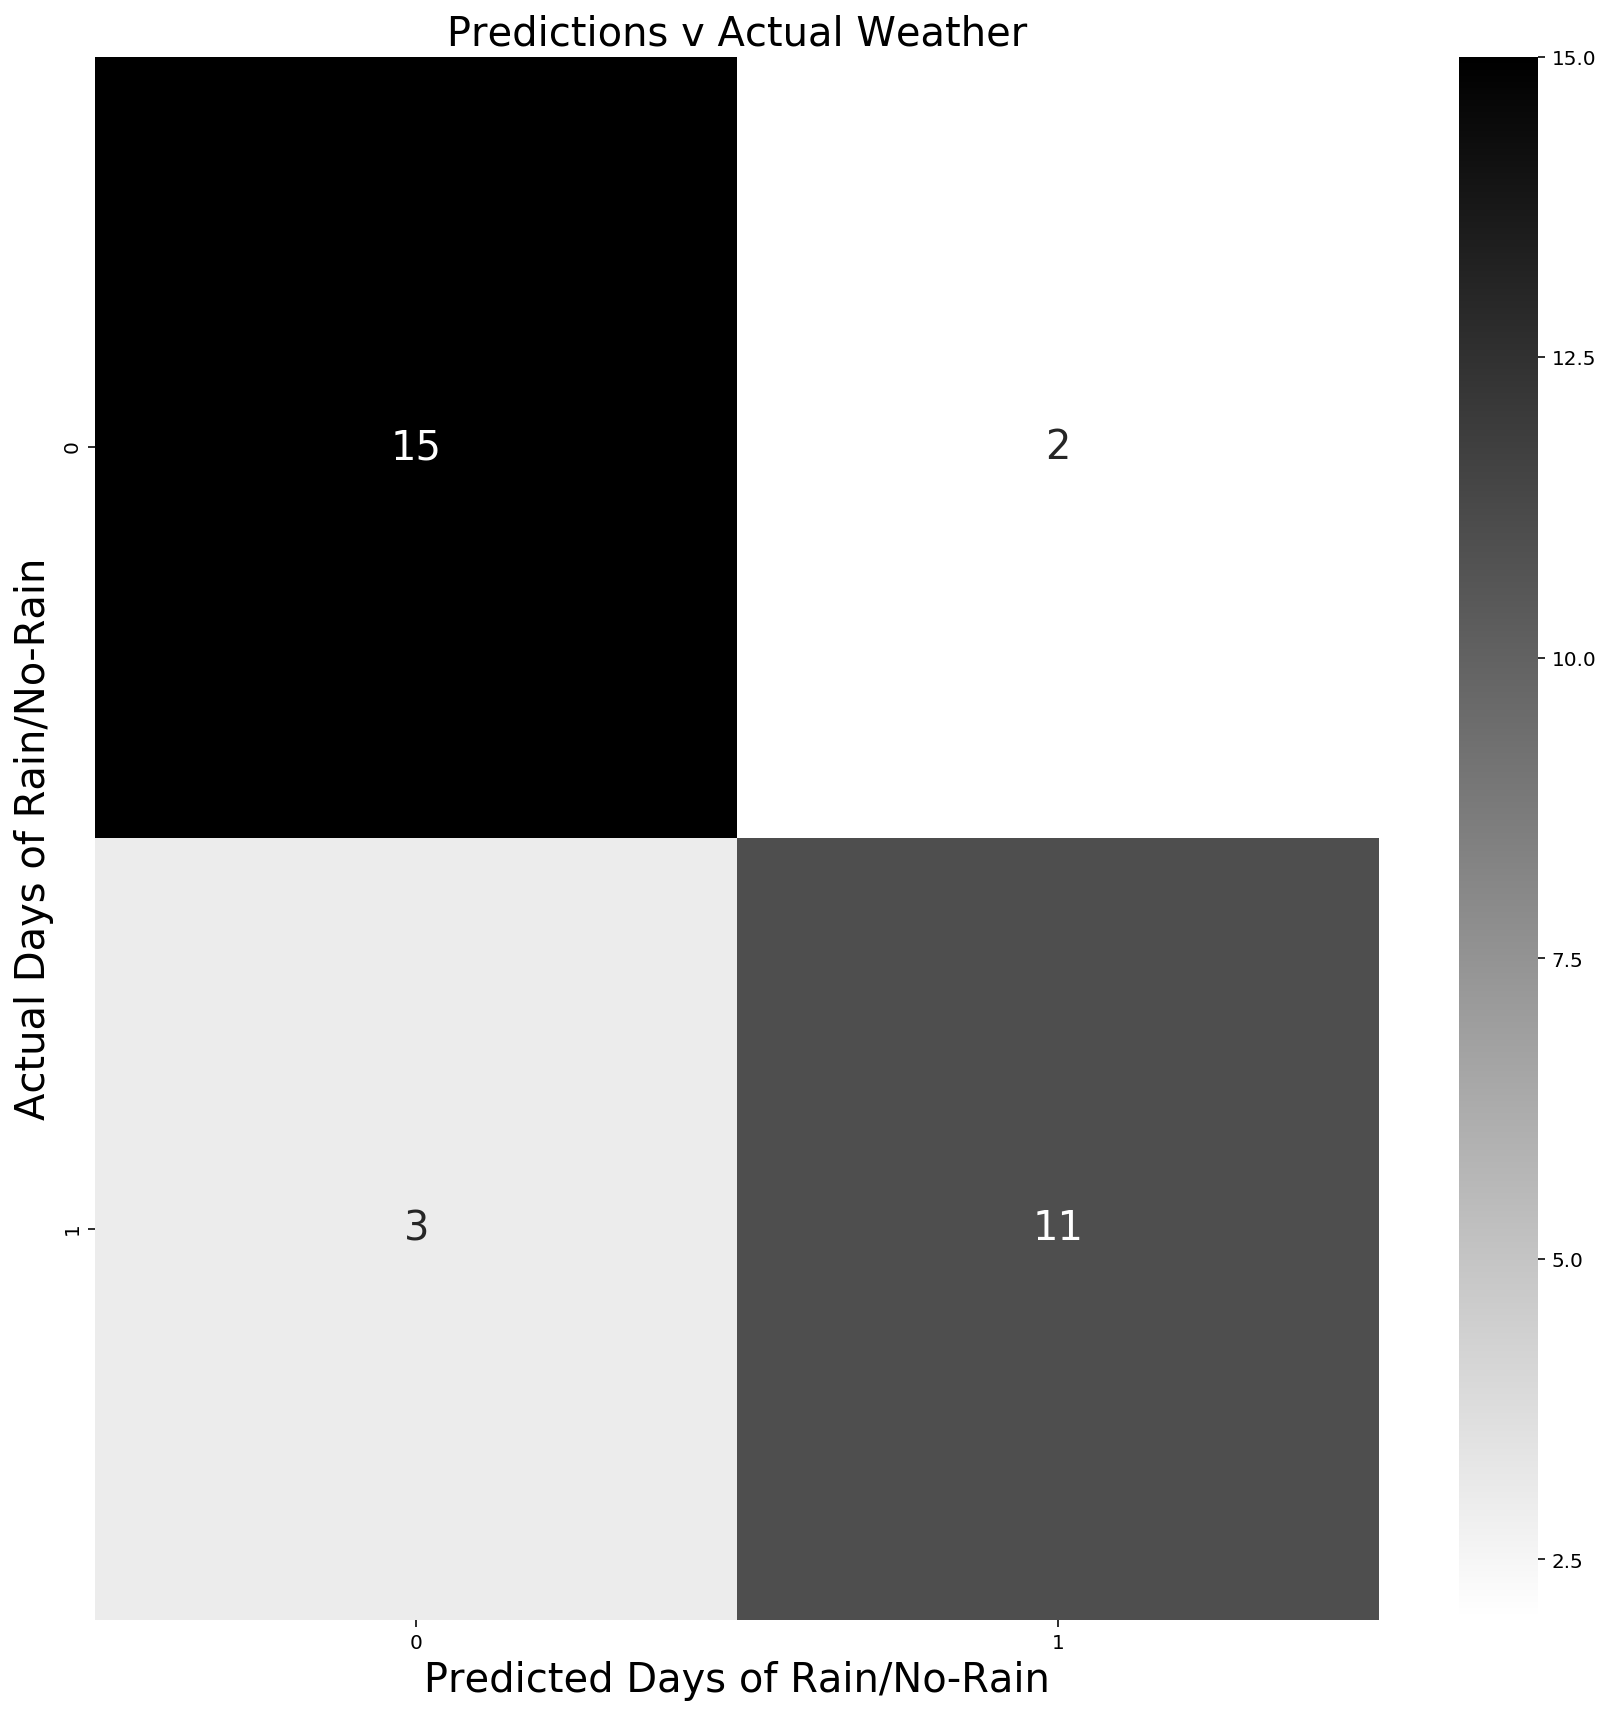

In [25]:
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt="d", cmap="gist_gray_r", annot_kws={"size": 20})
plt.title("Predictions v Actual Weather", fontsize=20)
plt.ylabel("Actual Days of Rain/No-Rain", fontsize=20)
plt.xlabel("Predicted Days of Rain/No-Rain", fontsize=20)
plt.tight_layout()

## RESULTS:
The Keras model performed better than the XGB model by correctly predicting one more day of rainy weather,ie, it correctly classified 26 rainy/dry days out of 31, compared to 25 for the XGB model.

The model wrongly predicted that it would rain on 2 days, when they were in fact sunny (false positives). It also wrongly predicted 3 sunny days when it in fact rained on those days (false negatives).

Like the XGB model, the Keras model is also weakest in terms of its recall score, in this case meaning its ability to correctly identify rainy days as such (11 out of 14).

The chart below gives us an easier way to see how the model performed with its predictions:

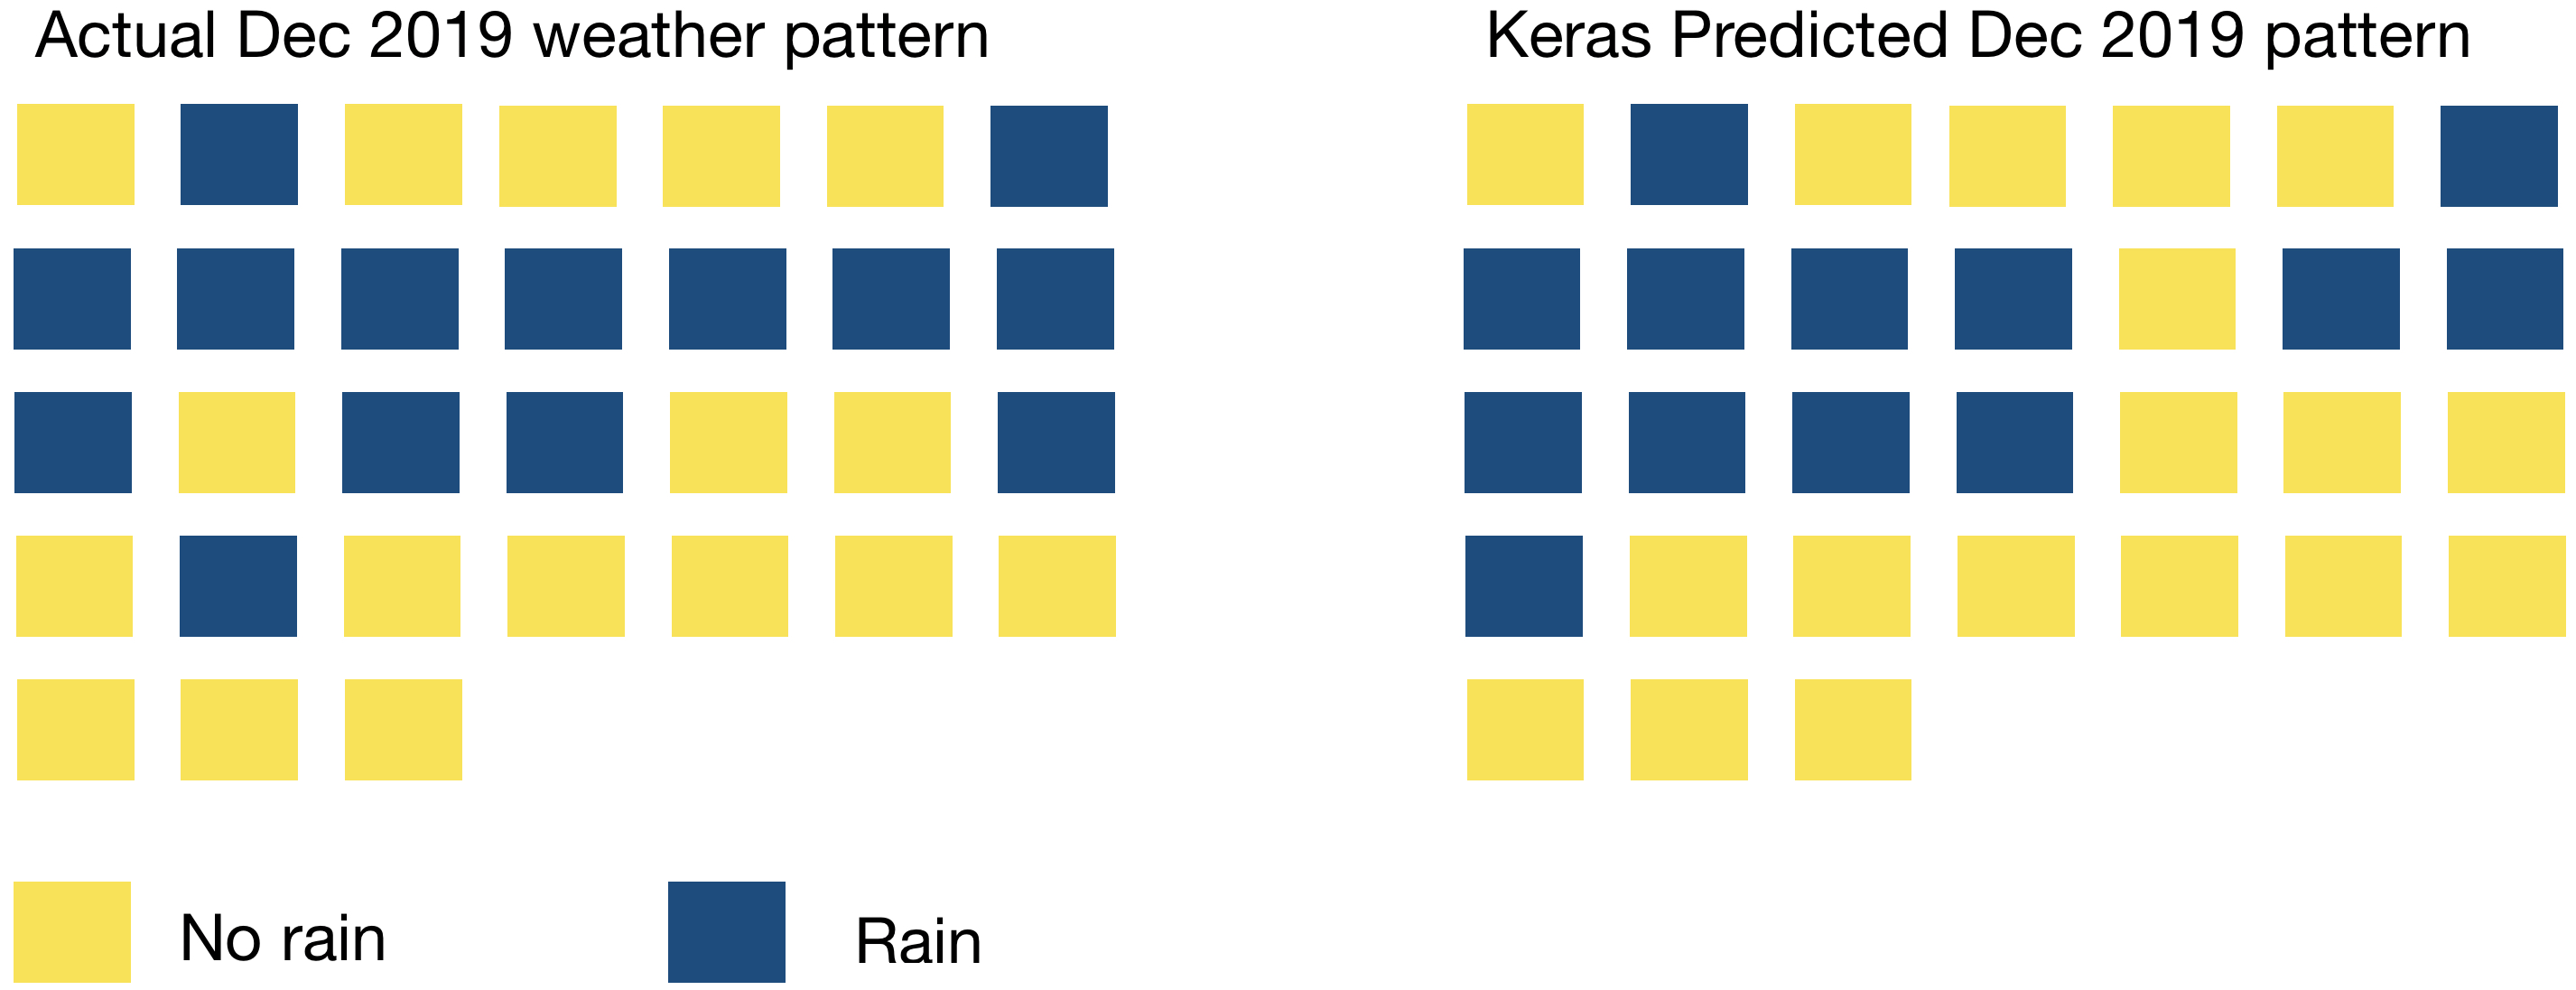

Finally, let's see if the new Keras Tuner can do better than this.